# Load Data

In [1]:
import tensorflow as tf

# Load the Fashion MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

## Data Prep

In [2]:
import numpy as np

train_filter = (y_train == 3) | (y_train == 5) | (y_train == 8)
x_train_nn = x_train[train_filter]
y_train_nn = y_train[train_filter]

test_filter = (y_test == 3) | (y_test == 5) | (y_test == 8)
x_test_nn = x_test[test_filter]
y_test_nn = y_test[test_filter]

# Convert to categorical labels:
# 3 -> 0, 5 -> 1, 8 -> 2
y_train_nn_bin = ((y_train_nn == 5).astype(int) + 2 * (y_train_nn == 8).astype(int))
y_test_nn_bin = ((y_test_nn == 5).astype(int) + 2 * (y_test_nn == 8).astype(int))

print("Unique values in training labels:", np.unique(y_train_nn_bin))
print("Label distribution in training set:", np.bincount(y_train_nn_bin))

Unique values in training labels: [0 1 2]
Label distribution in training set: [6131 5421 5851]


## Plot Data

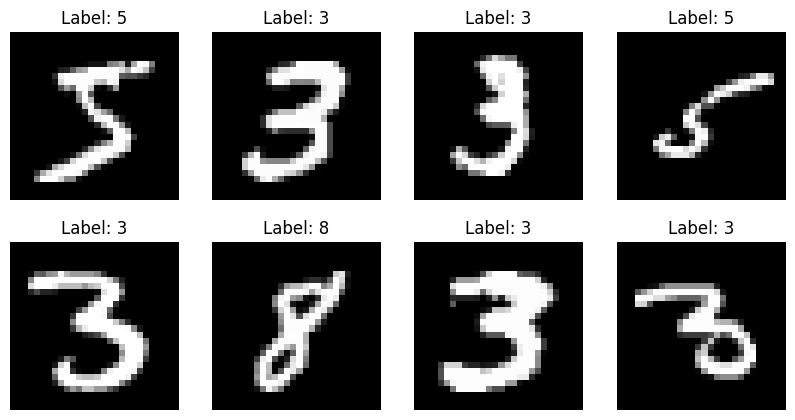

In [3]:
import matplotlib.pyplot as plt

def get_original_label(mapped_label):
    label_map = {0: 3, 1: 5, 2: 8}
    return label_map[mapped_label]

plt.figure(figsize=(10, 5))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_train_nn[i], cmap='gray')
    original_label = get_original_label(y_train_nn_bin[i])
    plt.title(f'Label: {original_label}')
    plt.axis('off')

plt.show()

# Transfer Learning

## Load and Modify Model

In [4]:
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

model = mobilenet_v2(pretrained=True)

# Modify the input layer for grayscale (1 channel)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)

# Modify the output layer for your dataset's number of classes
model.classifier[1] = nn.Linear(model.last_channel, 3)

print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

c:\Users\kaden\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kaden\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Modify Data to fit with Model

In [5]:
import torchvision.transforms as transforms
import torch

# Pre-trained models may not match the structure of our data.
# It's best to modify the model to handle the data, but we may need to adjust the images as well.
# Resize the images to 32x32 for the model

'Your code here'
# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# Convert numpy arrays to tensors and apply transformations
x_train_tensor = torch.stack([transform(img) for img in x_train_nn])
x_test_tensor = torch.stack([transform(img) for img in x_test_nn])

# Convert labels to tensors
y_train_tensor = torch.tensor(y_train_nn_bin, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_nn_bin, dtype=torch.long)


## Fit Model on our Data

In [9]:
import torch
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
model = model.to(device)
# Apply transformations to create resized tensors
x_train_nn_resized = x_train_tensor
x_test_nn_resized = x_test_tensor

# Create DataLoaders and move tensors to the same device as the model
y_train_tensor = torch.tensor(y_train_nn_bin, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test_nn_bin, dtype=torch.long).to(device)

train_dataset_resized = TensorDataset(x_train_nn_resized.to(device), y_train_tensor)
test_dataset_resized = TensorDataset(x_test_nn_resized.to(device), y_test_tensor)
train_loader_resized = DataLoader(train_dataset_resized, batch_size=64, shuffle=True)
test_loader_resized = DataLoader(test_dataset_resized, batch_size=64, shuffle=False)

# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model on resized data
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_resized:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    #print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader_resized)}')

# Evaluate the model on resized test data
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader_resized:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader_resized)
    avg_val_loss = val_loss / len(test_loader_resized)
    val_accuracy = correct / total
        
    # Print metrics rounded to 4 decimals
    print(f'Epoch {epoch + 1}/{num_epochs}, '
        f'Train Loss: {avg_train_loss:.4f}, '
        f'Validation Loss: {avg_val_loss:.4f}, '
        f'Validation Accuracy: {val_accuracy:.4f}')

print(f'Test Accuracy on resized data: {100 * correct / total}%')

Epoch 1/10, Train Loss: 0.0494, Validation Loss: 0.0515, Validation Accuracy: 0.9823
Epoch 2/10, Train Loss: 0.0299, Validation Loss: 0.0518, Validation Accuracy: 0.9861
Epoch 3/10, Train Loss: 0.0258, Validation Loss: 0.0092, Validation Accuracy: 0.9969
Epoch 4/10, Train Loss: 0.0157, Validation Loss: 0.0159, Validation Accuracy: 0.9951
Epoch 5/10, Train Loss: 0.0130, Validation Loss: 0.0140, Validation Accuracy: 0.9965
Epoch 6/10, Train Loss: 0.0073, Validation Loss: 0.0092, Validation Accuracy: 0.9969
Epoch 7/10, Train Loss: 0.0075, Validation Loss: 0.0117, Validation Accuracy: 0.9958
Epoch 8/10, Train Loss: 0.0100, Validation Loss: 0.0121, Validation Accuracy: 0.9955
Epoch 9/10, Train Loss: 0.0081, Validation Loss: 0.0150, Validation Accuracy: 0.9948
Epoch 10/10, Train Loss: 0.0121, Validation Loss: 0.0122, Validation Accuracy: 0.9969
Test Accuracy on resized data: 99.68706536856746%


## Confusion Matrix

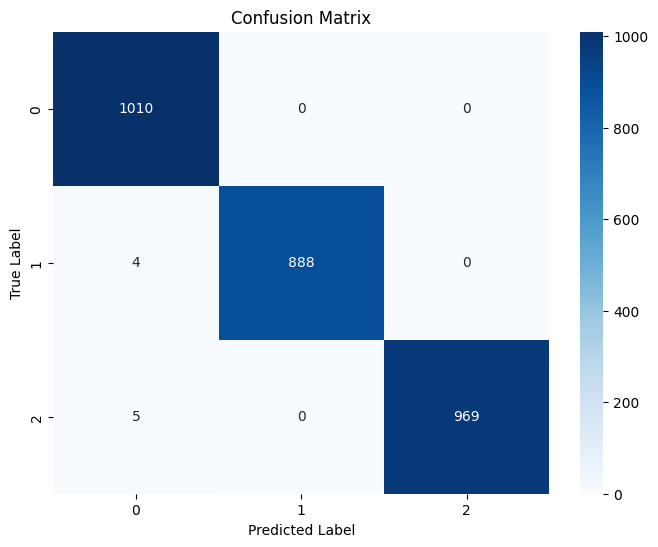

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute and plot a confusion matrix.

'Your code here'
# Get predictions for all test data
model.eval()
with torch.no_grad():
    all_outputs = model(x_test_tensor.to(device))
    _, all_predictions = torch.max(all_outputs, 1)

# Convert predictions to numpy for confusion matrix
y_true = y_test_tensor.cpu().numpy()
y_pred = all_predictions.cpu().numpy()

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Where are misclassifications occurring?
# How does your test accuracy compare to that of the Random Forest and CNN made previously?
# It's very possible that it won't be better than the CNN.
# Better than the other CNN and the random forest

## Plot Misclassifications

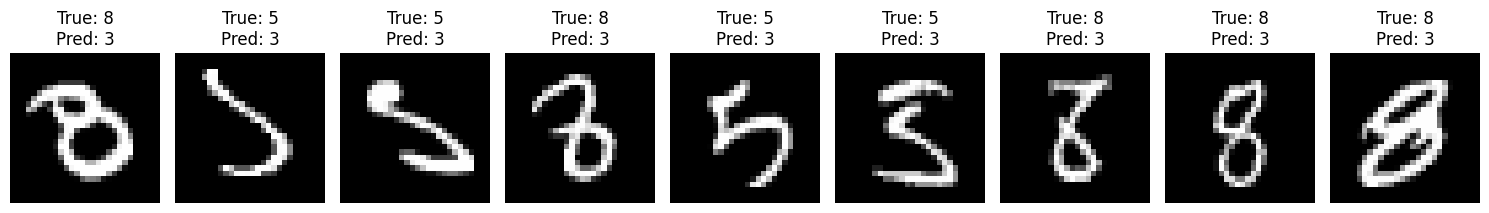

'Your code here'

In [11]:
# Plot some of the misclassifications.
# Find indices where predictions don't match true labels
misclassified_indices = np.where(y_pred != y_true)[0]

# Plot a few misclassified examples
plt.figure(figsize=(15, 5))
num_examples = min(9, len(misclassified_indices))

for i in range(num_examples):
    plt.subplot(1, num_examples, i + 1)
    idx = misclassified_indices[i]
    plt.imshow(x_test_nn[idx], cmap='gray')
    plt.title(f'True: {get_original_label(y_true[idx])}\nPred: {get_original_label(y_pred[idx])}')
    plt.axis('off')

plt.tight_layout()
plt.show()

'Your code here'

# Can you see why the model made the misclassifications it did?